In [126]:
import numpy as np
import astropy.units as u
from CenterOfMass2 import CenterOfMass
from ReadFile import Read
G = 4.498768e-6
def distance(x1, x2, y1, y2, z1, z2):
    # This function describes the absolute magnitude of the vector between (x1,y1,z1) and (x2, y2, z2)
    return np.sqrt(((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2))

In [162]:
class M33AnalyticOrbit:
    '''This class determines the acceleration of M33 from M31 and the Milky Way and integrates its orbit forwards in time'''
    
    def __init__(self, filename):
        # The below 7 lines find the position vector of M33 relative to M31, and stores it
        M31COM = CenterOfMass("M31_000.txt", 2)
        M33COM = CenterOfMass("M33_000.txt", 2)
        M31_COM_X, M31_COM_Y, M31_COM_Z = M31COM.COM_P(1)
        M33_COM_X, M33_COM_Y, M33_COM_Z = M33COM.COM_P(1)
        self.x = M33_COM_X - M31_COM_X
        self.y = M33_COM_Y - M31_COM_Y
        self.z = M33_COM_Z - M31_COM_Z
        
        # The below 5 lines find the velocity vector of M33 relative to M31, and stores it
        M31VXCOM, M31VYCOM, M31VZCOM = M31COM.COM_V(1)
        M33VXCOM, M33VYCOM, M33VZCOM = M33COM.COM_V(1) 
        self.vx = (M33VXCOM - M31VXCOM).to(u.kpc / u.Gyr)
        self.vy = (M33VYCOM - M31VYCOM).to(u.kpc / u.Gyr)
        self.vz = (M33VZCOM - M31VZCOM).to(u.kpc / u.Gyr)
        
        self.Rdisk = 5 # Disk scale length, in kpc
        self.Mdisk = 1.921e12 # Disk mass as computed in Set 3, in Msuns
        
        self.Rbulge = 1 # Bulge scale length, in kpc
        self.Mbulge = 1.905e10 # Bulge mass as computed in Set 3
        
        self.Rhalo = 62 # Halo scale length, in kpc, as computed in Set 5
        self.Mhalo = 1.200e11 # Halo mass as computed in Set 3
        
        self.filename = filename
    
    def HernquistAccel(self, M, ra, x, y, z, direction):
        '''This function takes as inputs the total halo or bulge mass M, the scale length ra, the x, y, and z coordinates
        and a dummy variable for direction (x = 0, y = 1, z = 2) and returns the acceleration in that direction'''
        r = distance(x, y, z, 0, 0, 0).value
        
        if direction == 0:
            return (-G * M / (r * (ra + r) ** 2) * x.value)* (u.kpc / u.Gyr / u.Gyr)
        
        if direction == 1:
            return (-G * M / (r * (ra + r) ** 2) * y.value) * (u.kpc / u.Gyr / u.Gyr)
        
        return (-G * M / (r * (ra + r) ** 2) * z.value) * (u.kpc / u.Gyr / u.Gyr)
    
    def MiyamotoNagaiAccel(self, M, rd, x, y, z, direction):
        '''This function takes as inputs the total disk mass M, the scale length rd, the x, y, and z coordinates
        and a dummy variable for direction (x = 0, y = 1, z = 2) and returns the acceleration in that direction'''
        
        zd = rd / 5
        
        B = rd + np.sqrt(z.value ** 2 + zd ** 2)
        r = distance(x, y, z, 0 * u.kpc, 0 * u.kpc, 0 * u.kpc).value
        
        if direction == 0:
            return (-G * M / ((r ** 2 + B ** 2) ** 1.5) * x.value) * (u.kpc / u.Gyr / u.Gyr) # Returns the acceleration in the x direction
        if direction == 1:
            return (-G * M / ((r ** 2 + B ** 2) ** 1.5) * y.value)* (u.kpc / u.Gyr / u.Gyr) # Returns the acceleration in the y direction
        
        return (-G * M * B * z.value / (np.sqrt(z.value ** 2 + zd ** 2) * (r ** 2 + B ** 2) ** 1.5)) * (u.kpc / u.Gyr / u.Gyr) 
        # Returns the acceleration in the z direction
    
    def M31Accel(self, x, y, z, direction):
        '''This function takes as inputs the x, y, and z coordinates and a dummy variable for direction 
        (x = 0, y = 1, z = 2) and returns the acceleration in that direction'''
        
        aHalo = self.HernquistAccel(self.Mhalo, self.Rhalo, x, y, z, direction)
        aBulge = self.HernquistAccel(self.Mbulge, self.Rbulge, x, y, z, direction)
        aDisk = self.MiyamotoNagaiAccel(self.Mdisk, self.Rdisk, x, y, z, direction)
        
        return aHalo + aBulge + aDisk
    
    def LeapFrog(self, dt, x, y, z, vx, vy, vz):
        '''This function takes as inputs a timestep, dt, and initial conditions (x, y, z), (vx, vy, vz) 
        and integrates the particle's motion to the next timestep'''
        
        halfX = x + vx * dt / 2.0 # Approximates the x position of the particle at the halfway point of the timestep
        halfY = y + vy * dt / 2.0
        halfZ = z + vz * dt / 2.0
        
        nextvx = vx + dt * self.M31Accel(halfX, halfY, halfZ, 0) # Approximates the x velocity of the particle at time t + dt
        nextvy = vy + dt * self.M31Accel(halfX, halfY, halfZ, 1)
        nextvz = vz + dt * self.M31Accel(halfX, halfY, halfZ, 2)

        nextX = x + (dt * (vx + nextvx) / 2.0) # Approximates the x position of the particle at time t + dt
        nextY = y + (dt * (vy + nextvy) / 2.0)
        nextZ = z + (dt * (vz + nextvz) / 2.0)
        
        return nextX, nextY, nextZ, nextvx, nextvy, nextvz
    
    def OrbitIntegrator(self, t0, dt, tmax):
        '''This function takes as input an initial time t0, a timestep dt, and a final time tmax.
        Given these, it calculates M33's future trajectory relative to M31 and outputs it to the file "M33.txt"'''
        
        Orbit = np.zeros((int((tmax - t0) / dt) + 2, 7)) # Stores orbital data
        
        t = t0 # Defines start data.
        
        x = self.x
        y = self.y
        z = self.z
        vx = self.vx
        vy = self.vy
        vz = self.vz
        
        Orbit[0][0] = t.value # Storing start data
        Orbit[0][1] = x.value
        Orbit[0][2] = y.value
        Orbit[0][3] = z.value
        Orbit[0][4] = vx.to(u.km / u.s).value
        Orbit[0][5] = vy.to(u.km / u.s).value
        Orbit[0][6] = vz.to(u.km / u.s).value
        
        index = 0
        
        while t < tmax:
            index += 1
            
            x, y, z, vx, vy, vz = self.LeapFrog(dt, x, y, z, vx, vy, vz)
            
            t += dt
            
            Orbit[index][0] = t.value # Storing new data
            Orbit[index][1] = x.value
            Orbit[index][2] = y.value
            Orbit[index][3] = z.value
            Orbit[index][4] = vx.to(u.km / u.s).value
            Orbit[index][5] = vy.to(u.km / u.s).value
            Orbit[index][6] = vz.to(u.km / u.s).value
            
        np.savetxt(self.filename, Orbit, header = 't x y z vx vy vz', comments = '#', fmt=['%.2f','%.2f','%.2f','%.2f','%.2f','%.2f','%.2f'])
        # This final line stores all the data in the file "filename"

In [166]:
M33Object = M33AnalyticOrbit("M33.txt")
M33Object.OrbitIntegrator(0 * u.Gyr, .001 * u.Gyr, 10 * u.Gyr)

Text(0.5,1,'Separation of M31 and M33 over time')

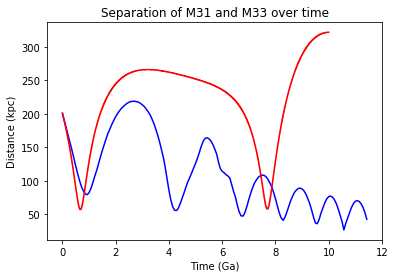

In [167]:
from matplotlib.pyplot import *
%matplotlib inline

M33Data = np.genfromtxt("M33.txt", dtype = None, names = True, skip_header = 0) # Opens M33 file and reads its data
M33OrbitData = np.genfromtxt("Orbit_M33.txt", dtype = None, names = True, skip_header = 0)
M31Data = np.genfromtxt("Orbit_M31.txt", dtype = None, names = True, skip_header = 0)

plot(M33OrbitData['t'], distance(M33OrbitData['x'], M31Data['x'], M33OrbitData['y'], M31Data['y'], M33OrbitData['z'], M31Data['z']), 'b')
plot(M33Data['t'], distance(0, M33Data['x'], 0, M33Data['y'], 0, M33Data['z']), 'r')
xlabel('Time (Ga)')
ylabel('Distance (kpc)')
title('Separation of M31 and M33 over time')

Text(0.5,1,'Relative velocity of M31 and M33 over time')

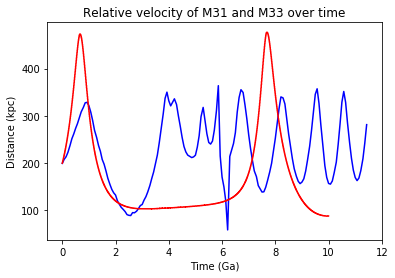

In [168]:
M33Data = np.genfromtxt("M33.txt", dtype = None, names = True, skip_header = 0) # Opens M33 file and reads its data
M33OrbitData = np.genfromtxt("Orbit_M33.txt", dtype = None, names = True, skip_header = 0)
M31Data = np.genfromtxt("Orbit_M31.txt", dtype = None, names = True, skip_header = 0)

plot(M33OrbitData['t'], distance(M33OrbitData['vx'], M31Data['vx'], M33OrbitData['vy'], M31Data['vy'], M33OrbitData['vz'], M31Data['vz']), 'b')
plot(M33Data['t'], distance(0, M33Data['vx'], 0, M33Data['vy'], 0, M33Data['vz']), 'r')
xlabel('Time (Ga)')
ylabel('Relative Velocity (km/s)')
title('Relative velocity of M31 and M33 over time')

(2) The two plots show that the simulated predictions are similar until about 1 Ga, at which point they diverge wildly. (3) This is presumably due to interactions with the Milky Way, which your simulation (in blue) accounted for, while mine did not. (4) We could account for the Milky Way by including it in the simulation, and allowing all three bodies to interact gravitationally and through friction, simulating all three simultaneously.